In [ ]:
#Install python packages in anaconda

# Install missiong pachages
# https://anaconda.org/anaconda/numpy
# https://anaconda.org/conda-forge/matplotlib
# https://anaconda.org/anaconda/pandas
# https://anaconda.org/anaconda/scipy

# conda install -c anaconda numpy
# conda install -c conda-forge matplotlib
# conda install -c anaconda pandas
# conda install -c anaconda scipy
# conda install -c anaconda astropy
# conda install -c conda-forge stingray

In [70]:
import numpy as np
#from uncertainties import ufloat, unumpy
#from uncertainties.umath import *
from astropy.io import fits
from astropy.table import Table
import scipy.stats as st

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

#from astropy.stats import LombScargle
from scipy import signal
import warnings
warnings.filterwarnings("ignore")

import astropy.io.fits as pyfits

from stingray.pulse.search import epoch_folding_search, z_n_search

from scipy.signal import savgol_filter
import scipy.optimize



from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile

In [13]:
## some lines for stylish purposhes... try disabling them or commenting them out and see what changes in plots.

##specify notebook style, following lines help with interactive plots, i.e. show values as you hover mouse pointer
plt.style.use('seaborn-notebook')
%matplotlib notebook

## Next two lines help with setting max width on cell. 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Next 3 lines help with default color on plots, i.e. balck or white Backgorund color
import seaborn as sns
sns.set(context='notebook',style='dark')
plt.style.use(['dark_background'])

## Play with python plots of fits images

In [16]:
# we load a fits file
image_file1 = 'nu30202035002A01_cl.evt.gz'
imfits = pyfits.open(image_file1)

# a fits file is essentially a table and some extra information
# we care about table of data which is in extension "[1]" of the file, have a look on the file with topcat or ds9 as well
im = imfits[1].data

In [17]:
#see the columns of the table
print(im.dtype)

(numpy.record, [('TIME', '>f8'), ('PRIOR', '>f8'), ('NUMRISE', '>i4'), ('DENRISE', '>i4'), ('SUBFRM', '>i4'), ('PREPHAS', '>i2', (9,)), ('POSTPHAS', '>i2', (9,)), ('RESET', '>f8'), ('TRIGGERS', 'u1', (2,)), ('DET_ID', 'u1'), ('S_CAP', 'u1'), ('HWTRIG', 'u1'), ('RAWX', 'u1'), ('RAWY', 'u1'), ('MODE', 'u1'), ('STIM', 'u1'), ('UP', 'u1'), ('SHIELD', 'u1'), ('SHLD_T', 'u1'), ('SHLD_HI', 'u1'), ('STATUS', 'u1', (2,)), ('BADPOS', 'u1', (1,)), ('HOTPOS', 'u1', (1,)), ('RAWPHAS', '>i2', (9,)), ('OFFPHAS', '>f4', (9,)), ('TRPHAS', '>f4', (9,)), ('PHAS', '>f4', (9,)), ('GRADE', '>i2'), ('SWTRIG', 'u1', (9,)), ('PIS_GAIN', '>f4', (9,)), ('SURRPI', '>i4'), ('PI_CLC', '>f4'), ('PI', '>i4'), ('DET1X', '>i2'), ('DET1Y', '>i2'), ('DET2X', '>i2'), ('DET2Y', '>i2'), ('X', '>i2'), ('Y', '>i2')])


In [18]:
# you can print individual columns by ussing their name
print(im['TIME'])
print(im['PI'])

[2.19599126e+08 2.19599129e+08 2.19599129e+08 ... 2.19927316e+08
 2.19927316e+08 2.19927316e+08]
[  32 3560 1379 ... 3443   25 1070]


<IPython.core.display.Javascript object>


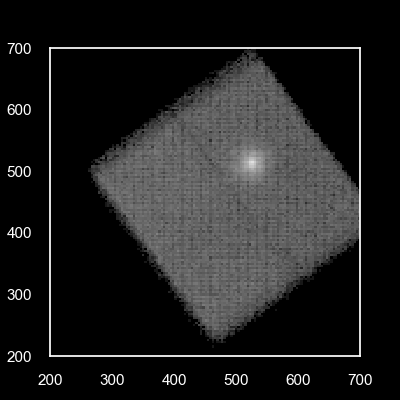

In [21]:
# you can define a position of a photon by its CCD pixel coordinate and plot it like with ds9
x = im['X']
y = im['Y']

plt.close('all')
fig1=plt.figure(1,figsize=(4,4))
plt.hist2d(x, y, bins=(200, 200),cmap=mpl.cm.gray,norm=mpl.colors.LogNorm())
plt.xlim(200,700)
plt.ylim(200,700)
plt.show()

In [22]:
# in the above plot you see a point source round coordinates 500,500,
#here is a function to measure the distance of each photon from the central point
# the funstion returns a table with equal size as the number of events you pass into the pable, and "True/False" values depending if the photon is inside or outside the radious.
def in_circle(center_x, center_y, radius, x, y):
    square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
    return square_dist <= radius ** 2

In [23]:
# We call the above function using the center we find, e.g. 520,510, and a radious in pixel coordinates of 50
# can you define the center and size/extend of the point source more accuratly?
dist = in_circle(520.0,510.0,50,x,y)

<IPython.core.display.Javascript object>


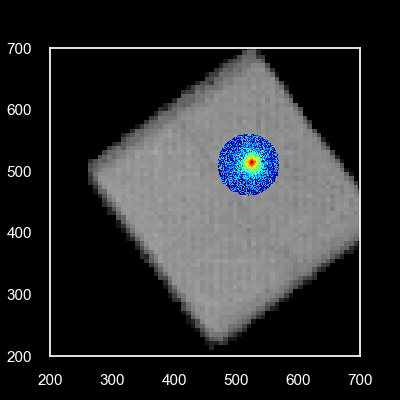

In [26]:
#here we plot the same image as above in grey scale, and the photons we selected in color scale.

plt.close('all')
fig1=plt.figure(1,figsize=(4,4))
plt.hist2d(x, y, bins=(100, 100),cmap=mpl.cm.gray,norm=mpl.colors.LogNorm())
plt.hist2d(x[dist], y[dist], bins=(100, 100), cmap=plt.cm.jet,norm=mpl.colors.LogNorm())
plt.xlim(200,700)
plt.ylim(200,700)
plt.show()

## Here we start the timing analysis

In [38]:
# We can use photons/events that were detected inside the cyrcle defioned above 
times0 = im['time']
PI0=im['PI']
times = times0[dist]
PI = PI0[dist]

# The PI column is calculated from the measure of the charge in the CCD camera created from each photon, and can be translated to energy in keV (cgs)
# Nustar E = Channel Number * 0.04 keV + 1.6 keV
mask1 = (PI*0.04+1.6>3) & (PI*0.04+1.6<=30)
print(PI.min(), PI.max())

times1 = times[mask1]

0 4095


In [36]:
## This is an optional step
#instead of using the above file, we can use directly cleaned events selected fron two NuSTAR detectors.
# by merging these 2 files we increase our statistics, but we have to merge the two lists

# image_file1 = 'nu30202035002A01_cl_sc_bary.fits'
# imfits = pyfits.open(image_file1)
# im1 = imfits[1].data

# image_file2 = 'nu30202035002B01_cl_sc_bary.fits'
# imfits2 = pyfits.open(image_file2)
# im2 = imfits2[1].data

# times0 = np.append(im1['time'],im2['time'])
# PI0 = np.append(im1['PI'],im1['PI'])

# mask1 = (PI*0.04+1.6>3) & (PI*0.04+1.6<=30)

# times1 = times[mask1]

<IPython.core.display.Javascript object>


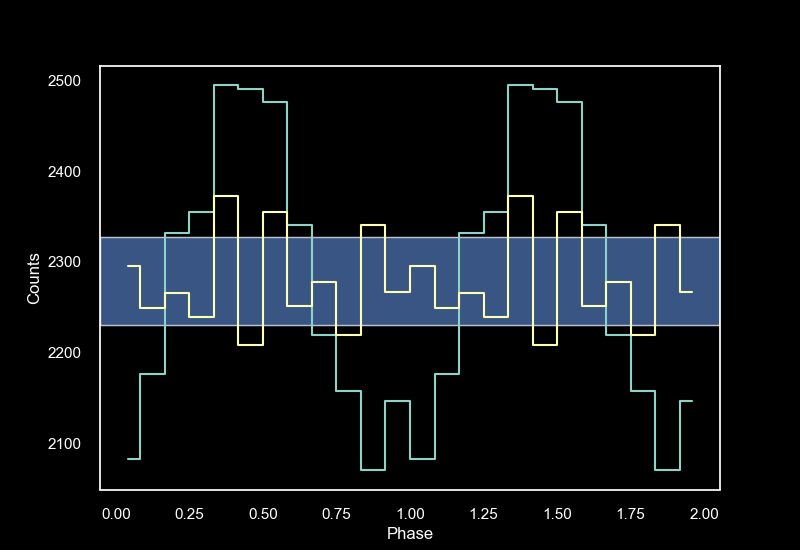

In [39]:
nbin = 12
period = 31.62

ph, profile, profile_err = fold_events(times, 1/period, nbin=nbin)
_ = plot_profile(ph, profile)


# random time
ph, profile, profile_err = fold_events(times, 1/21, nbin=nbin)
_ = plot_profile(ph, profile)

<IPython.core.display.Javascript object>


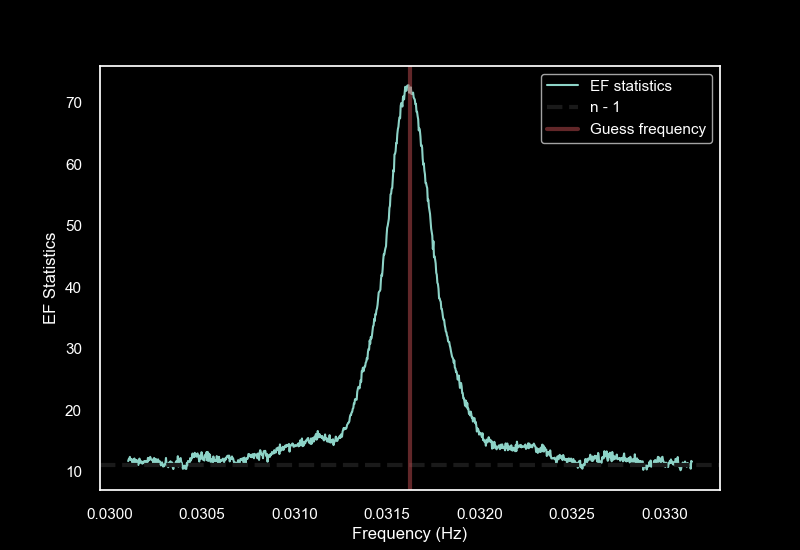

In [43]:
# We will search for pulsations over a range of frequencies around the known pulsation period.
# we search between a amximum and minimum period... ask us in the classroom why we define them these way.
# the default step is 1/T where T is the duration of the observations. we can do more fine steps by increasing the oversampling parameter i.e. a value of 10 will give 10 times larger grid.
obs_length = times.max()-times.min()
df_min = 1/obs_length
oversampling=1
df = df_min / oversampling

frequencies = np.arange(1/period - 500 * df, 1/period + 500 * df, df)


freq, efstat = epoch_folding_search(times, frequencies, nbin=nbin)

# ---- PLOTTING --------
plt.figure()
plt.plot(freq, efstat, label='EF statistics')
plt.axhline(nbin - 1, ls='--', lw=3, color='k', label='n - 1')
plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='Guess frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
_ = plt.legend()


In [45]:
#instead of using the epoch folding functions, we can define our own function to search for periodic signal.

def phases(times,freq,bins):
    arr = []
    for i in range(len(freq)):
        phase_time = times%(1/freq[i])
        hist, bin_edges = np.histogram(phase_time,bins)
        stdev = np.std(hist)
        arr = np.append(arr,stdev)
    
    return arr

In [46]:
#Optional: if you are interested in period search tests have a look here...
# https://github.com/StingraySoftware/notebooks/blob/main/Pulsar/Pulsar%20search%20with%20epoch%20folding%20and%20Z%20squared.ipynb

In [47]:
# lets run our function the event times 
times_ev = times - np.min(times)
bins=12
phase_test = phases(times_ev,frequencies,bins)

<IPython.core.display.Javascript object>


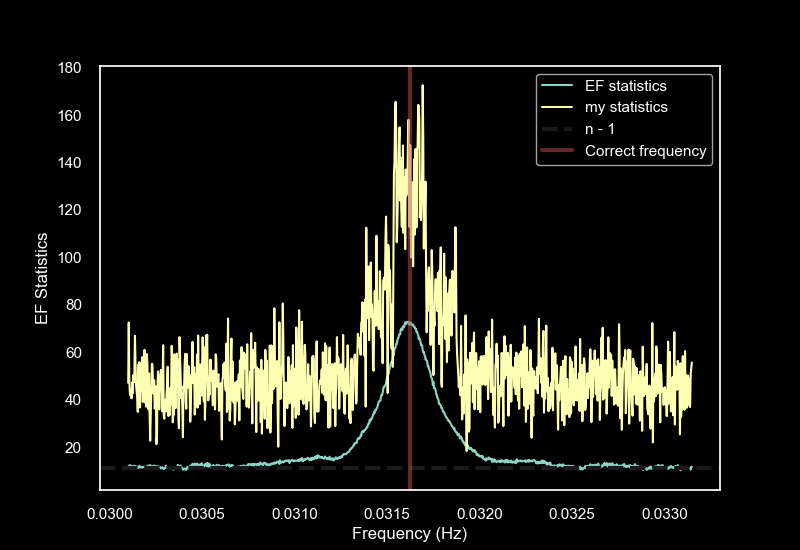

In [49]:
# We can compare our method with the one from  the "black box" tool.. it should be close.

plt.figure()
plt.plot(freq, efstat, label='EF statistics')
plt.plot(frequencies, phase_test, label='my statistics')
plt.axhline(nbin - 1, ls='--', lw=3, color='k', label='n - 1')
plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='Correct frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
_ = plt.legend()

In [50]:
#lets remember what is the total duration of the observations

print(np.max(times1)-np.min(times1))

328179.74272352457


<IPython.core.display.Javascript object>


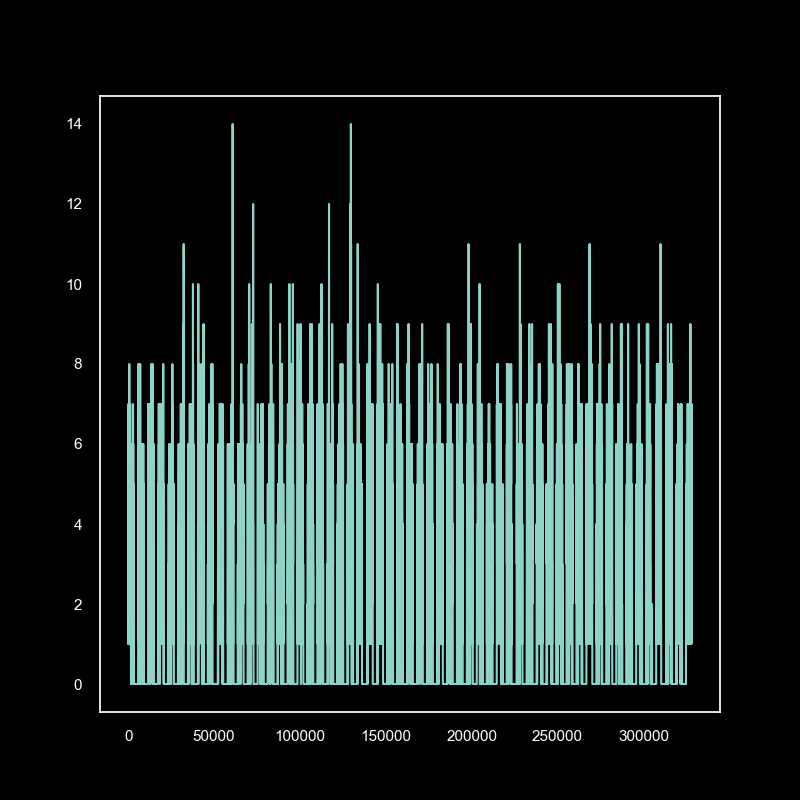

328179.74272352457


In [54]:
plt.close('all')
fig1=plt.figure(1,figsize=(8,8))

print(np.max(times1)-np.min(times1))

hist1, bin_edges1 = np.histogram(times1-np.min(times1), 10000)

# try creating a histogram with different number of bins, here i used a bin of ~1 sec
# hist1, bin_edges1 = np.histogram(times1-np.min(times1),328179)

# or you can try a bin size of ~100 seconds
# hist1, bin_edges1 = np.histogram(times1-np.min(times1),3280)

bin_mean1 = (bin_edges1[1:] + bin_edges1[0:-1])/2
plt.plot(bin_mean1,hist1)

# try to zoom in deferent time period...
# plt.xlim(0,20000)

In [62]:
# here we can run a mask and select events within a time period of the above plot.
# we can trey for the first 30 ks and last 30 ks.

mask1 = (times_ev>0) & (times_ev<30000)
mask2 = (times_ev>270000) & (times_ev<300000)
mask3 = (times_ev>50000) & (times_ev<100000)

power_dt1 = phases(times_ev[mask1],frequencies,10)
power_dt2 = phases(times_ev[mask2],frequencies,10)
power_dt3 = phases(times_ev[mask3],frequencies,10)

<IPython.core.display.Javascript object>


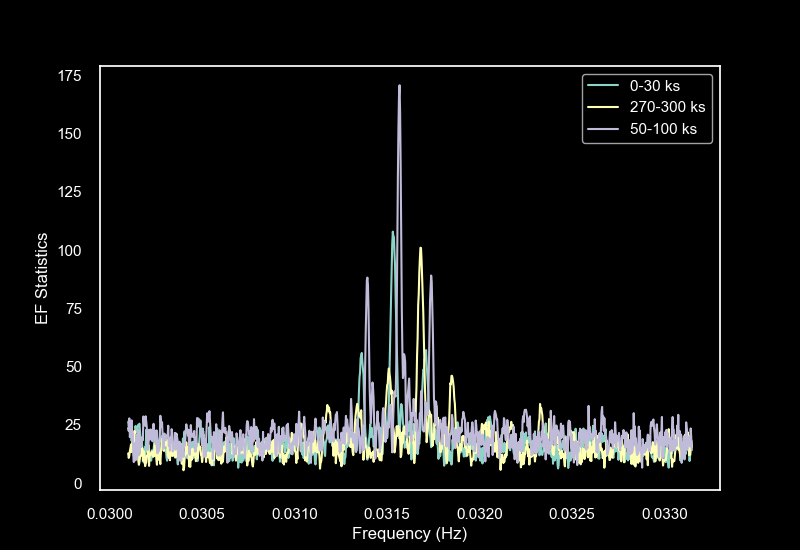

In [66]:
plt.figure()

plt.plot(frequencies, power_dt1, label='0-30 ks')
plt.plot(frequencies, power_dt2, label='270-300 ks')
plt.plot(frequencies, power_dt3, label='50-100 ks')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
# plt.xlim(0.0312,0.0322)
_ = plt.legend()

In [64]:
#get frequencies of peaks
max_f1 = frequencies[np.argmax(power_dt1)]
max_f2 = frequencies[np.argmax(power_dt2)]
max_f3 = frequencies[np.argmax(power_dt3)]
print(max_f1,max_f2,max_f3)

0.03153109441362205 0.03168040062796511 0.031567659200808104


<IPython.core.display.Javascript object>


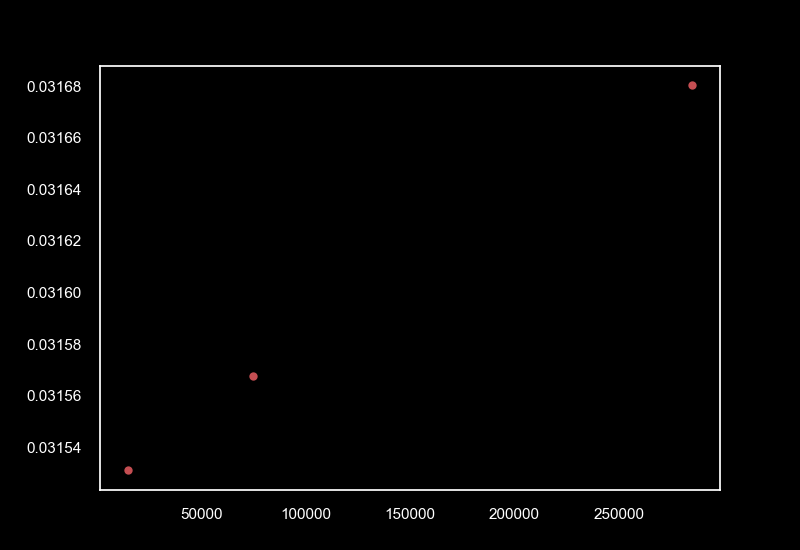

In [67]:

# Crete array of times and frequencies
T = [15000,285000,75000]
F = [max_f1,max_f2,max_f3]

plt.close('all')
plt.plot(T,F,'ro')
# add axis with labels... 

In [81]:
# We can fit a line
#define a function and using the curve fit functions, which returns best fit an a matrix for "errors".
# The variance of parameters are the diagonal elements of the variance-co variance matrix, and the standard error is the square root of it

def lin(x, a, b):
    x = np.array(x)
    return a*x + b

fit_params, pcov = scipy.optimize.curve_fit(lin,T,F)

print('best fit:',fit_params)
print('errors:',np.sqrt(np.diag(pcov)))

x_fit = [np.min(T),np.max(T)]
y_fit = lin(x_fit, *fit_params)

best fit: [5.48774984e-10 3.15244545e-02]
errors: [1.31284939e-11 2.23666892e-06]


<IPython.core.display.Javascript object>


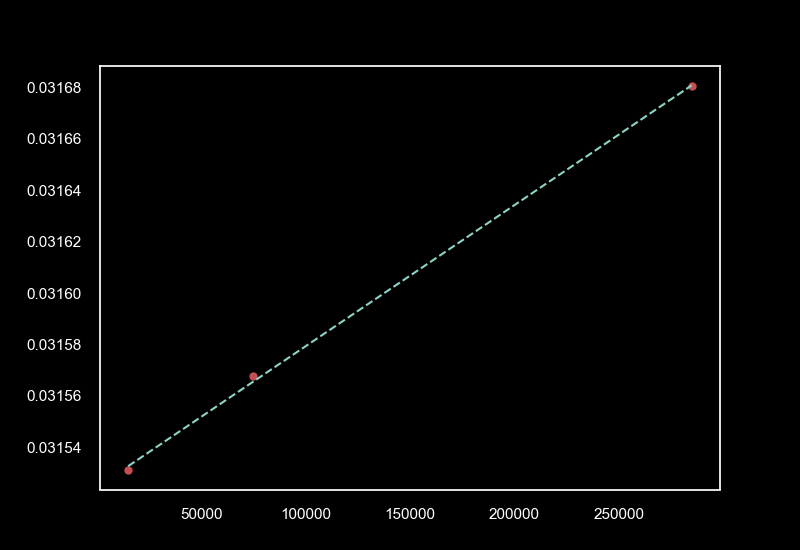

In [82]:
#lets have a look at the fit...
plt.close('all')
plt.plot(T,F,'ro')
plt.plot(x_fit,y_fit,'--')

#